# Day 1
## Pneumonia Use Case Part 1

In this notebook, we will put our newly developed Python skills to use. We will analyze a dataset of ICU patients from the MIMIC-II database.

1. Exploratory data analysis
2. Wrangle data
3. Calculate the relative risk (RR) of variables with 30-day mortality
4. Perform survival analysis to study the cumulative incidence of 30-day mortality and study the association of pneumonia with 30-day mortality

**Study population**: All patients in MIMIC-II who were discharged from the ICU and are at least 18 years old.

In [6]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
sns.set()

## 0. Read in data

In [7]:
FILEPATH = "../data/pna_30_day_mortality.csv"
os.path.exists(FILEPATH)

True

#### TODO
Read in the CSV file under `../data/pna_30_day_mortality.csv`

In [5]:
df = pd.read_csv(FILEPATH)

In [33]:
len(df)

5074

In [34]:
df.head()

,subject_id,hadm_id,disch_dt,dod,sex,ethnicity_descr,age_at_discharge,age_at_discharge_binned,pna,time_discharge_to_death,mortality_30_day
0,56,28766,2644-01-23 00:00:00,2644-01-23 00:00:00,F,WHITE,90.7205,91+,0,0,1
1,37,18052,3264-08-19 00:00:00,3265-12-31 00:00:00,M,WHITE,68.9863,66-90,1,499,0
2,78,15161,2778-03-27 00:00:00,2781-03-11 00:00:00,M,BLACK/AFRICAN AMERICAN,48.6658,36-65,0,1080,0
3,67,35878,2976-11-29 00:00:00,2976-11-29 00:00:00,M,WHITE,73.5397,66-90,0,0,1
4,3,2075,2682-09-18 00:00:00,2683-05-02 00:00:00,M,WHITE,76.6055,66-90,0,226,0


## 1. Exploratory data analysis

#### TODO
Our first analysis will be exploring the dataset using visualization and summary statistics. We will answer questions like:
- What are the demographics of the patient population?
- How many patients died in the hospital? How long did patients survive after discharge?
- How many patients had pneumonia? Does the subpopulation of pneumonia cases differ at all from the rest of the population?

But first, you may need to do some additional data transformations to get the necessary variables. Start by exploring the dataset and getting familiar with it. Which of the previous analyses can you do? Which do you need to do additional work for?

In [16]:
df.head()

,subject_id,hadm_id,disch_dt,dod,sex,ethnicity_descr,age_at_discharge,age_at_discharge_binned,pna,time_to_death,mortality_30_day
0,56,28766,2644-01-23 00:00:00,2644-01-23 00:00:00,F,WHITE,90.7205,91+,0,0,1
1,37,18052,3264-08-19 00:00:00,3265-12-31 00:00:00,M,WHITE,68.9863,66-90,1,499,0
2,78,15161,2778-03-27 00:00:00,2781-03-11 00:00:00,M,BLACK/AFRICAN AMERICAN,48.6658,36-65,0,1080,0
3,67,35878,2976-11-29 00:00:00,2976-11-29 00:00:00,M,WHITE,73.5397,66-90,0,0,1
4,3,2075,2682-09-18 00:00:00,2683-05-02 00:00:00,M,WHITE,76.6055,66-90,0,226,0


In [25]:
df["in_hospital_mortality"] = (df["disch_dt"] == df["dod"]).astype(int)

<AxesSubplot:>

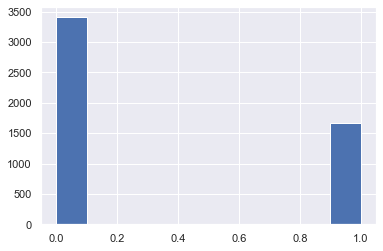

In [27]:
df["in_hospital_mortality"].hist()

<AxesSubplot:xlabel='count', ylabel='ethnicity_descr'>

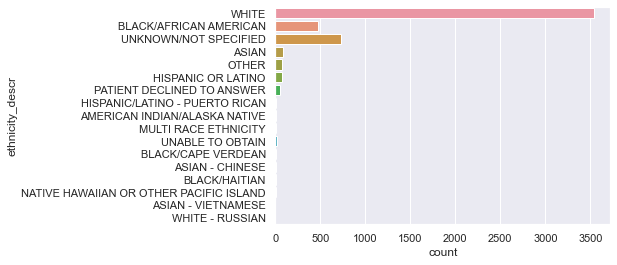

In [23]:
sns.countplot(y="ethnicity_descr", data=df)

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age_at_discharge', ylabel='Density'>

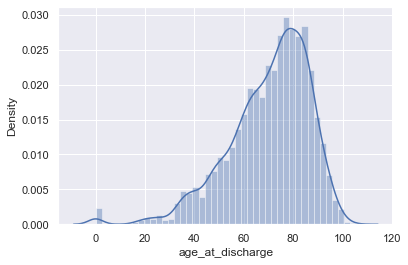

In [24]:
sns.distplot(df["age_at_discharge"])

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age_at_discharge_binned', ylabel='count'>

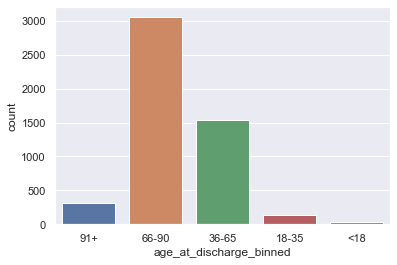

In [28]:
sns.countplot(df["age_at_discharge_binned"])

#### TODO
Add a column `"in_hospital_mortality"` which is 1 if the patient died while in the hospital and 0 otherwise.

*Hint:* How do you know whether they died in the hospital?

In [ ]:
df["in_hospital_mortality"] = (df["disch_dt"] == df["dod"]).astype(int)

#### TODO
Add a column to your dataframe called `binned_age_at_discharge` with the following levels:
- "<18"
- "18-35"
- "36-65"
- "66-90"
- "91+"

In [30]:
def bin_age_at_discharge(age):
    # todo
    pass

#### TODO
Add a column `mortality_30_day` indicating whether the patient died within 30 days of discharge.

In [36]:
df["mortality_30_day"] = (df["time_discharge_to_death"] <= 30).astype(int)

## Putting it all together: survival analysis
Next we'll utilize all the Python skills we've learned today to do a **survival analysis** on our dataset. We'll implement the [Kaplain-Meier method](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) from scratch and use it to analyze the post-discharge outcomes for patients in our dataset.

### Overview of Kaplan-Meier

#### Step 1: Filter the dataset to patients who did not die in the hospital and died within 30 days. Call it `df_dc` (short for "discharged")

In [99]:
df.head()

,subject_id,hadm_id,disch_dt,dod,sex,ethnicity_descr,age_at_discharge,age_at_discharge_binned,pna,time_discharge_to_death,mortality_30_day
0,56,28766,2644-01-23 00:00:00,2644-01-23 00:00:00,F,WHITE,90.7205,91+,0,0,1
1,37,18052,3264-08-19 00:00:00,3265-12-31 00:00:00,M,WHITE,68.9863,66-90,1,499,0
2,78,15161,2778-03-27 00:00:00,2781-03-11 00:00:00,M,BLACK/AFRICAN AMERICAN,48.6658,36-65,0,1080,0
3,67,35878,2976-11-29 00:00:00,2976-11-29 00:00:00,M,WHITE,73.5397,66-90,0,0,1
4,3,2075,2682-09-18 00:00:00,2683-05-02 00:00:00,M,WHITE,76.6055,66-90,0,226,0


In [110]:
df_dc = df.query("0 < time_discharge_to_death")

In [111]:
len(df_dc)

3391

In [112]:
df_dc.head()

,subject_id,hadm_id,disch_dt,dod,sex,ethnicity_descr,age_at_discharge,age_at_discharge_binned,pna,time_discharge_to_death,mortality_30_day
1,37,18052,3264-08-19 00:00:00,3265-12-31 00:00:00,M,WHITE,68.9863,66-90,1,499,0
2,78,15161,2778-03-27 00:00:00,2781-03-11 00:00:00,M,BLACK/AFRICAN AMERICAN,48.6658,36-65,0,1080,0
4,3,2075,2682-09-18 00:00:00,2683-05-02 00:00:00,M,WHITE,76.6055,66-90,0,226,0
5,26,15067,3079-03-10 00:00:00,3080-12-22 00:00:00,M,UNKNOWN/NOT SPECIFIED,72.0712,66-90,0,653,0
8,61,7149,3352-07-26 00:00:00,3353-02-09 00:00:00,M,WHITE,54.7808,36-65,0,198,0


#### Step 2: Group the data by time_to_discharge_death

In [189]:
df_daily = df_dc.groupby("time_discharge_to_death").size().sort_index().to_frame("n_deaths").reset_index()

In [190]:
df_daily

,time_discharge_to_death,n_deaths
0,1,30
1,2,36
2,3,22
3,4,23
4,5,17
...,...,...
1351,2612,1
1352,2622,1
1353,2654,1
1354,2677,1


#### Step 3: Implement the Kaplan Meier algorithm


In [191]:
total_n_at_risk = len(df_dc)
curr_n_at_risk = len(df_dc)
print(curr_count_at_risk)
total_deaths = []
daily_n_at_risk = []


for i in range(0, len(df_by_day)):
    n_deaths = df_daily.iloc[i]["n_deaths"]
    daily_n_at_risk.append(curr_count_at_risk)
    curr_n_at_risk -= n_deaths
    
    if i > 0:
        total_deaths.append(total_deaths[-1] + n_deaths)
    else:
        total_deaths.append(0 + n_deaths)

0


In [192]:
len(daily_at_risk)

1356

In [193]:
len(df_daily)

1356

In [194]:
df_daily["n_at_risk"] = daily_at_risk
df_daily["p_death"] = df_daily["n_deaths"] / df_daily["n_at_risk"]
df_daily["total_died"] = total_deaths
df_daily["p_death_running"] = df_daily["total_died"] / total_n_at_risk

In [195]:
df_daily.head()

,time_discharge_to_death,n_deaths,n_at_risk,p_death,total_died,p_death_running
0,1,30,3391,0.008847,30,0.008847
1,2,36,3361,0.010711,66,0.019463
2,3,22,3325,0.006617,88,0.025951
3,4,23,3303,0.006963,111,0.032734
4,5,17,3280,0.005183,128,0.037747


#### TODO
What is the probability of dying within 30 days of discharge?

In [202]:
df_daily.query("time_discharge_to_death == 30")

,time_discharge_to_death,n_deaths,n_at_risk,p_death,total_died,p_death_running
29,30,8,2961,0.002702,438,0.129165


#### Step 4: Put it all into a function
 
#### Advanced
If you want to come up with really clean code you could break it up into multiple functions.

In [245]:
def kaplan_meier(df, max_days=None):
    # Wrangle data
    df_dc = df.query("0 < time_discharge_to_death")
    df_daily = df_dc.groupby("time_discharge_to_death").size().sort_index().to_frame("n_deaths").reset_index()
    
    # Kaplan-Meier algorithm
    total_n_at_risk = len(df_dc)
    curr_n_at_risk = len(df_dc)
    total_deaths = []
    daily_n_at_risk = []

    for i in range(0, len(df_daily)):
        n_deaths = df_daily.iloc[i]["n_deaths"]
        daily_n_at_risk.append(curr_n_at_risk)
        curr_n_at_risk -= n_deaths

        if i > 0:
            total_deaths.append(total_deaths[-1] + n_deaths)
        else:
            total_deaths.append(0 + n_deaths)
            
    
    # Add new columns and return
    df_daily["n_at_risk"] = daily_n_at_risk
    df_daily["p_death"] = df_daily["n_deaths"] / df_daily["n_at_risk"]
    df_daily["total_died"] = total_deaths
    df_daily["p_death_running"] = df_daily["total_died"] / total_n_at_risk
    
    return df_daily
    

In [246]:
df_daily = kaplan_meier(df)

#### Step 6
Next let's plot the mortality curve. 

In [247]:
def plot_mortality_curve(df_daily, max_days=None, label=None):
    if max_days is not None:
        df_daily = df_daily.query(f"time_discharge_to_death <= {max_days}")
    ax = sns.lineplot(x="time_discharge_to_death", y="p_death_running", data=df_daily, drawstyle='steps-pre', label=label)
    if label is not None:
        ax.legend()
    return ax

<AxesSubplot:xlabel='time_discharge_to_death', ylabel='p_death_running'>

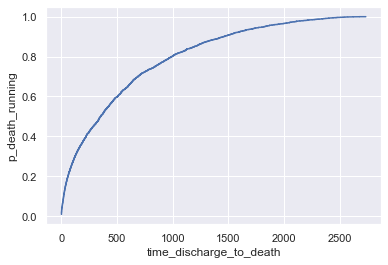

In [248]:
plot_mortality_curve(df_daily)

<AxesSubplot:xlabel='time_discharge_to_death', ylabel='p_death_running'>

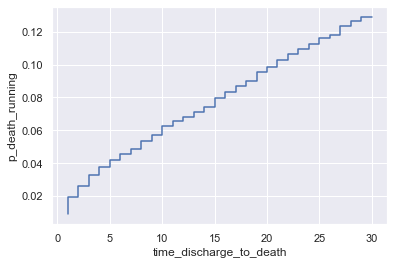

In [249]:
plot_mortality_curve(df_daily, max_days=30)

#### Step 5: Comparing groups
Next, break up your dataset into patients with and without pneumonia and calculate risk of mortality separately. Then consider the following questions:
- What can you say about the difference in 30-day mortality between the two groups?
- For pneumonia patients, which day in the first 30 days has the highest risk?
- Which day has the lowest risk?

In [253]:
df_daily_pna = kaplan_meier(df.query("pna == 1"))
df_daily_pna_neg = kaplan_meier(df.query("pna == 0"))

In [254]:
df_daily_pna.tail()

,time_discharge_to_death,n_deaths,n_at_risk,p_death,total_died,p_death_running
422,2069,1,5,0.200000,606,0.993443
423,2174,1,4,0.250000,607,0.995082
424,2202,1,3,0.333333,608,0.996721
425,2405,1,2,0.500000,609,0.998361
426,2533,1,1,1.000000,610,1.000000


In [255]:
df_daily_pna.query("time_discharge_to_death == 30")

,time_discharge_to_death,n_deaths,n_at_risk,p_death,total_died,p_death_running
29,30,3,519,0.00578,94,0.154098


In [256]:
df_daily_pna_neg.query("time_discharge_to_death == 30")

,time_discharge_to_death,n_deaths,n_at_risk,p_death,total_died,p_death_running
29,30,5,2442,0.002048,344,0.123697


<AxesSubplot:xlabel='time_discharge_to_death', ylabel='p_death_running'>

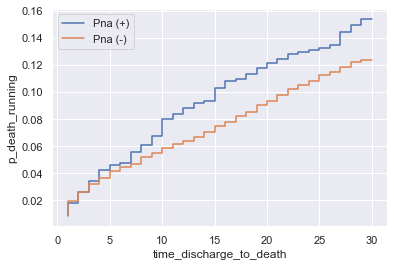

In [257]:
plot_mortality_curve(df_daily_pna, max_days=30, label="Pna (+)")
plot_mortality_curve(df_daily_pna_neg, max_days=30, label="Pna (-)")

In [259]:
# Day with highest risk
df_daily_pna.query("time_discharge_to_death <= 30").sort_values("p_death", ascending=False)

,time_discharge_to_death,n_deaths,n_at_risk,p_death,total_died,p_death_running
10,11,8,569,0.014060,49,0.080328
27,28,6,528,0.011364,88,0.144262
15,16,6,553,0.010850,63,0.103279
1,2,6,605,0.009917,11,0.018033
7,8,5,581,0.008606,34,0.055738
4,5,5,589,0.008489,26,0.042623
3,4,5,594,0.008418,21,0.034426
2,3,5,599,0.008347,16,0.026230
0,1,5,610,0.008197,5,0.008197
9,10,4,573,0.006981,41,0.067213


In [260]:
# Day with lowest risk
df_daily_pna.query("time_discharge_to_death <= 30").sort_values("p_death", ascending=True)

,time_discharge_to_death,n_deaths,n_at_risk,p_death,total_died,p_death_running
6,7,1,582,0.001718,29,0.047541
14,15,1,554,0.001805,57,0.093443
17,18,1,544,0.001838,67,0.109836
23,24,1,532,0.001880,79,0.129508
24,25,1,531,0.001883,80,0.131148
25,26,1,530,0.001887,81,0.132787
26,27,1,529,0.001890,82,0.134426
5,6,2,584,0.003425,28,0.045902
11,12,2,561,0.003565,51,0.083607
13,14,2,556,0.003597,56,0.091803


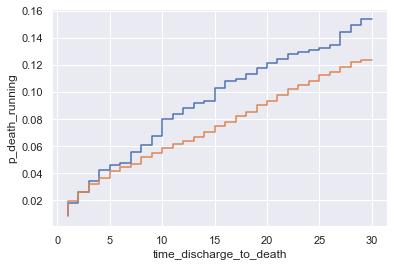

In [216]:
ax = sns.lineplot(x="time_discharge_to_death", y="p_death_running", data=df_daily_pna.iloc[:30], drawstyle='steps-pre')
ax = sns.lineplot(x="time_discharge_to_death", y="p_death_running", data=df_daily_pna_neg.iloc[:30], drawstyle='steps-pre')


<AxesSubplot:xlabel='time_discharge_to_death', ylabel='p_death_running'>

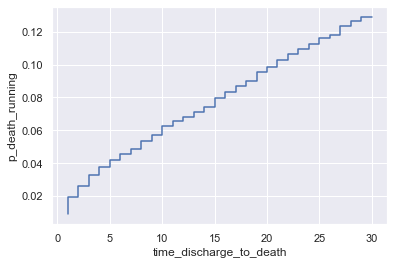

In [200]:
sns.lineplot(x="time_discharge_to_death", y="p_death_running", data=df_daily.iloc[:30], drawstyle='steps-pre')

<AxesSubplot:xlabel='time_discharge_to_death', ylabel='p_death_running'>

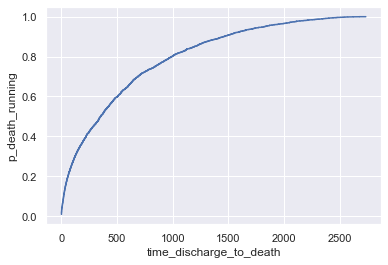

In [201]:
sns.lineplot(x="time_discharge_to_death", y="p_death_running", data=df_daily, drawstyle='steps-pre')

In [187]:
len(df[(df["time_discharge_to_death"] <= 30) & (df["time_discharge_to_death"] >0)])

438

In [37]:
!pip install scikit-survival

     |████████████████████████████████| 754 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 8.0 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 654 kB/s eta 0:00:01
     |████████████████████████████████| 249 kB 745 kB/s eta 0:00:01
     |████████████████████████████████| 99 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 1.9 MB/s eta 0:00:01


#### TODO
Filter the dataset to only patients who did not die in the hospital.

In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(df["Status"], df["Survival_in_days"])

#### TODO (advanced)
Using the columns ..., implement a simple regression.